In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Set up paths
BASE_PATH = '/workspace/COMP-3608---PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODELS_PATH = os.path.join(BASE_PATH, 'models')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')

In [28]:
# Create models directory if it doesn't exist
for path in [MODELS_PATH, RESULTS_PATH]:
    if not os.path.exists(MODELS_PATH):
        os.makedirs(MODELS_PATH)

In [29]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [30]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [31]:
# Function to evaluate and compare models
def evaluate_models(X_train, X_test, y_train, y_test, dataset_name):
    # Create models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'-'*50}")
        print(f"Training and evaluating {name} on {dataset_name} dataset")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'model': model,
            'predictions': y_pred,
            'probabilities': y_prob
        }
        
        # Print metrics
        print(f"\nModel: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, ['Negative', 'Positive'], f'Confusion Matrix - {name} ({dataset_name})')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc, f'ROC Curve - {name} ({dataset_name})')
        
        # Save model
        model_filename = os.path.join(MODELS_PATH, f"{dataset_name}_{name.replace(' ', '_').lower()}.pkl")
        joblib.dump(model, model_filename)
        print(f"Model saved to {model_filename}")
    
    return results

In [32]:
# Define helper function to prepare data for modeling
def prepare_data_for_modeling(df, target_column, categorical_cols=None, numerical_cols=None):
    
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        # Remove ID columns and target from numerical features if present
        numerical_cols = [col for col in numerical_cols if col != target_column and 'id' not in col.lower()]
    
    # Ensure target column is removed from features
    categorical_cols = [col for col in categorical_cols if col != target_column]
    numerical_cols = [col for col in numerical_cols if col != target_column]
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ])
    
    # Split data
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    return X_train_resampled, X_test_processed, y_train_resampled, y_test


Loading Diabetes Dataset...



--------------------------------------------------
Training and evaluating Logistic Regression on diabetes dataset

Model: Logistic Regression
Accuracy: 0.8940
Precision: 0.4385
Recall: 0.8812
F1 Score: 0.5856

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.44      0.88      0.59      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.89      0.76     20000
weighted avg       0.94      0.89      0.91     20000



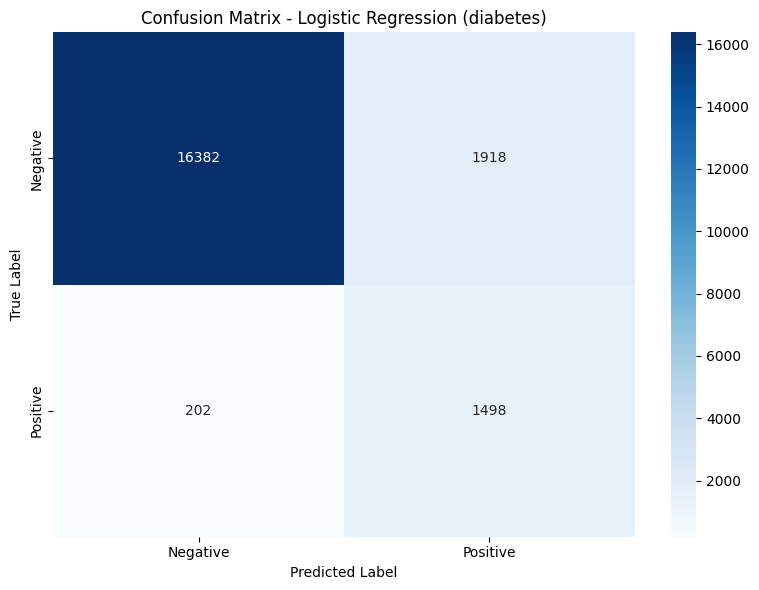

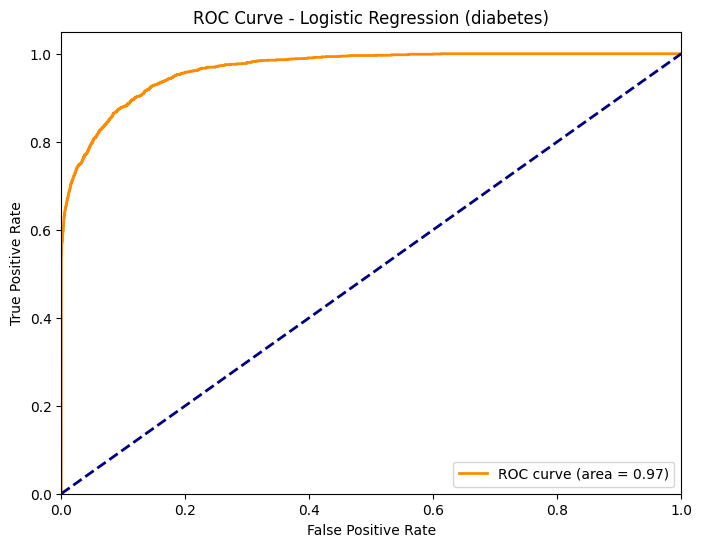

Model saved to /workspace/COMP-3608---PROJECT/models/diabetes_logistic_regression.pkl

--------------------------------------------------
Training and evaluating Random Forest on diabetes dataset

Model: Random Forest
Accuracy: 0.9577
Precision: 0.7563
Recall: 0.7412
F1 Score: 0.7487

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.76      0.74      0.75      1700

    accuracy                           0.96     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.96      0.96      0.96     20000



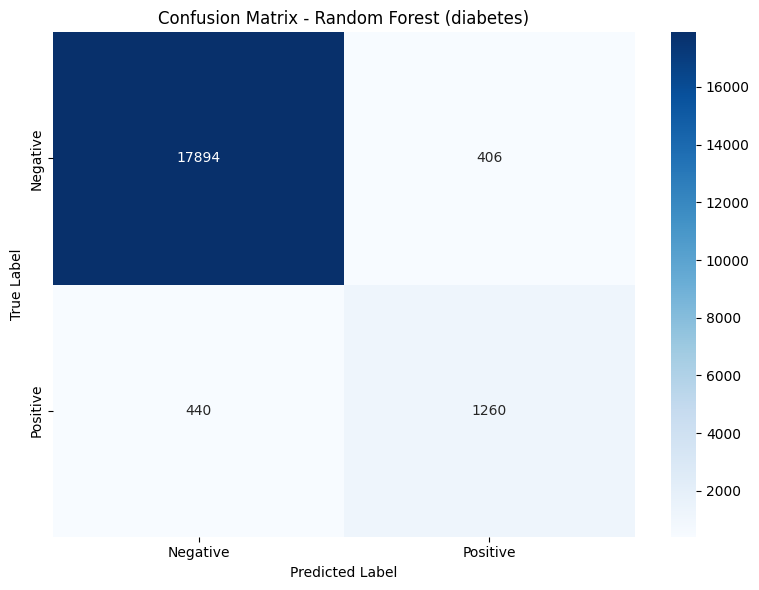

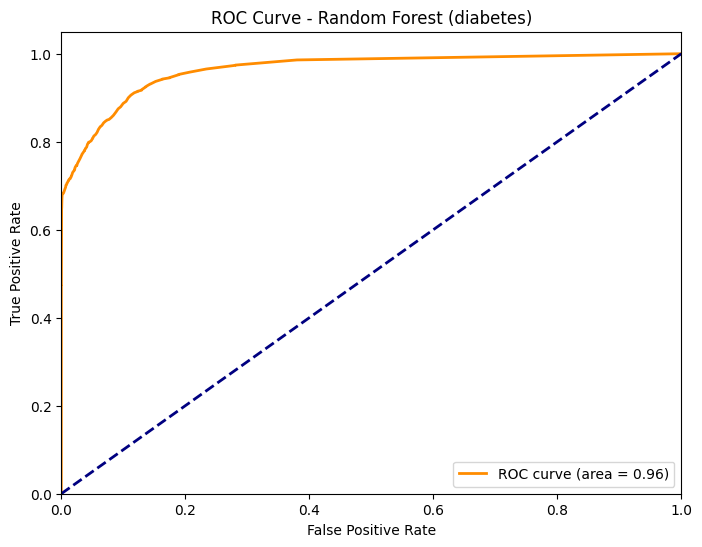

Model saved to /workspace/COMP-3608---PROJECT/models/diabetes_random_forest.pkl

--------------------------------------------------
Training and evaluating XGBoost on diabetes dataset

Model: XGBoost
Accuracy: 0.9694
Precision: 0.9103
Recall: 0.7100
F1 Score: 0.7978

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.91      0.71      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.94      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



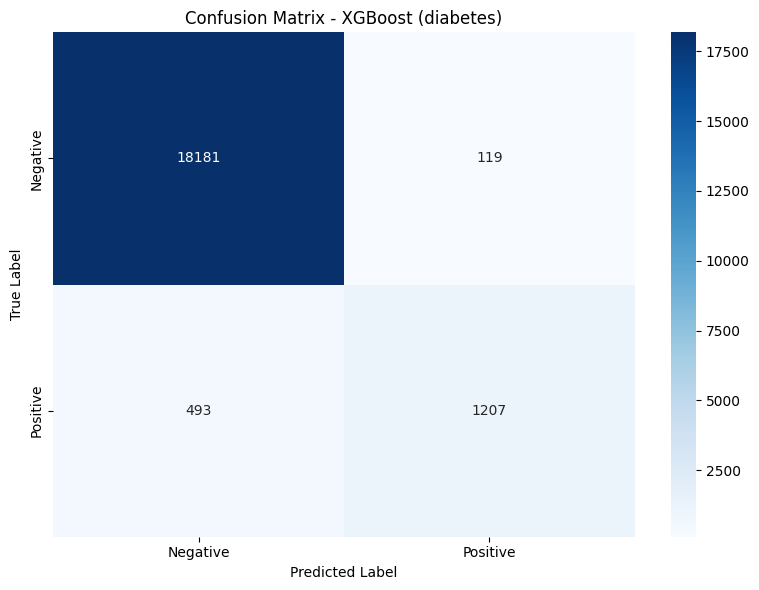

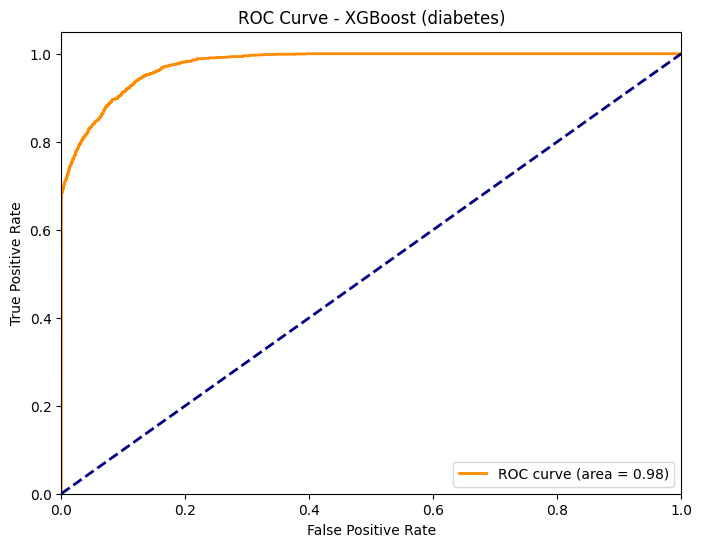

Model saved to /workspace/COMP-3608---PROJECT/models/diabetes_xgboost.pkl


In [33]:
# DIABETES DATASET EVALUATION
print("Loading Diabetes Dataset...")
diabetes_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/diabetes_feature_engineering'))

# Define categorical and numerical columns for diabetes
diabetes_cat_cols = ['gender', 'smoking_history', 'age_group', 'bmi_category', 'glucose_tolerance']
diabetes_num_cols = [col for col in diabetes_df.columns if col not in diabetes_cat_cols + ['diabetes']]

# Prepare data
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = prepare_data_for_modeling(
    diabetes_df, 'diabetes', diabetes_cat_cols, diabetes_num_cols)

# Evaluate models
diabetes_results = evaluate_models(X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes, 'diabetes')


Loading Stroke Dataset...

--------------------------------------------------
Training and evaluating Logistic Regression on stroke dataset

Model: Logistic Regression
Accuracy: 0.7573
Precision: 0.1439
Recall: 0.8000
F1 Score: 0.2439

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.80      0.24        50

    accuracy                           0.76      1022
   macro avg       0.57      0.78      0.55      1022
weighted avg       0.95      0.76      0.83      1022



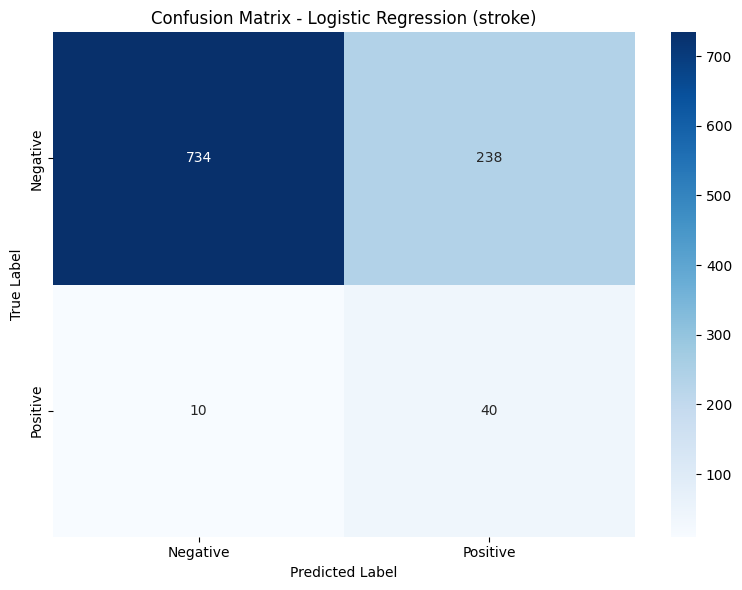

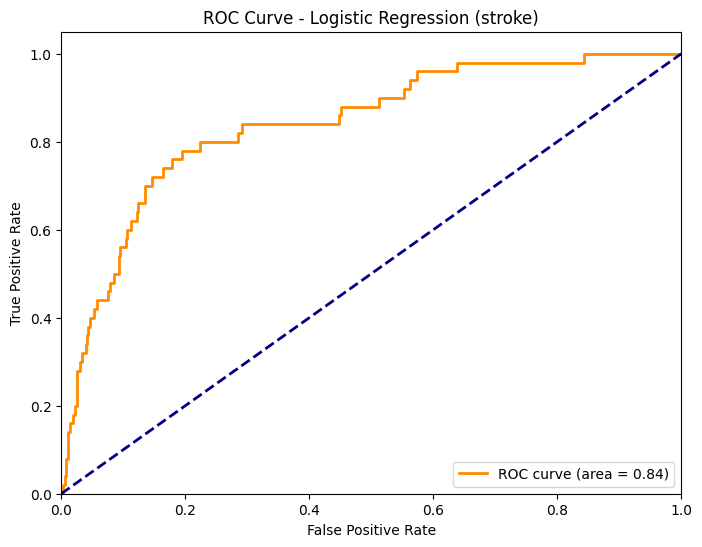

Model saved to /workspace/COMP-3608---PROJECT/models/stroke_logistic_regression.pkl

--------------------------------------------------
Training and evaluating Random Forest on stroke dataset

Model: Random Forest
Accuracy: 0.8865
Precision: 0.1887
Recall: 0.4000
F1 Score: 0.2564

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       972
           1       0.19      0.40      0.26        50

    accuracy                           0.89      1022
   macro avg       0.58      0.66      0.60      1022
weighted avg       0.93      0.89      0.91      1022



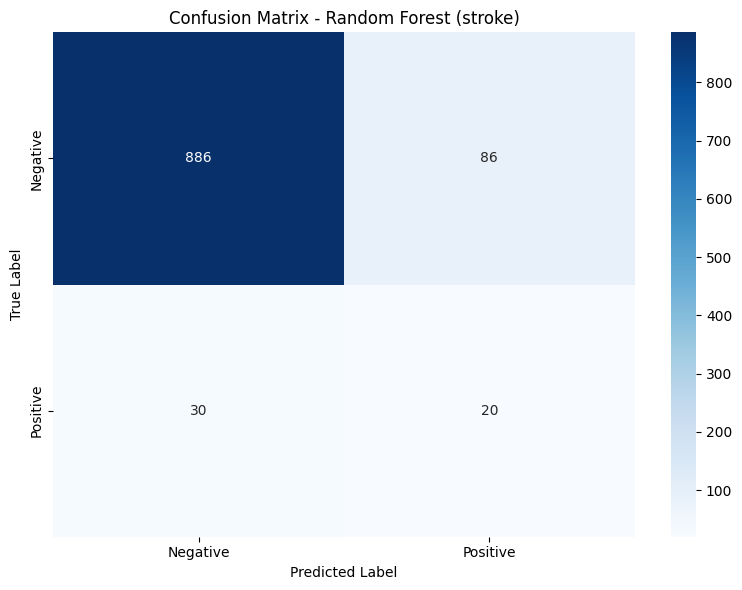

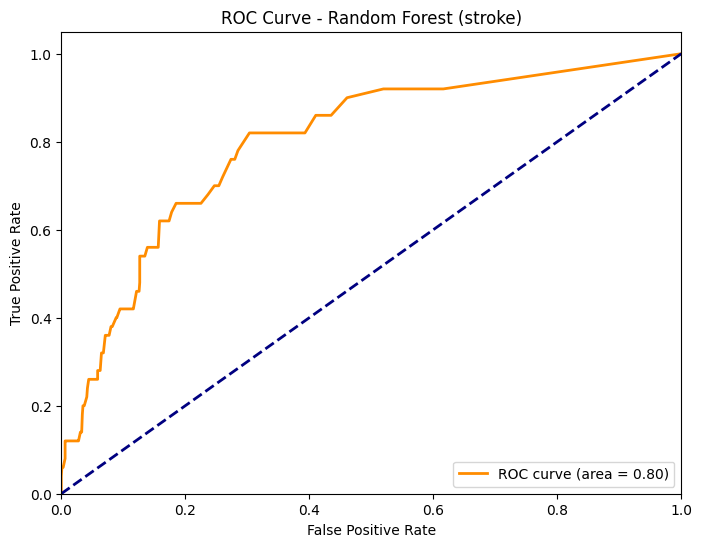

Model saved to /workspace/COMP-3608---PROJECT/models/stroke_random_forest.pkl

--------------------------------------------------
Training and evaluating XGBoost on stroke dataset

Model: XGBoost
Accuracy: 0.8933
Precision: 0.1446
Recall: 0.2400
F1 Score: 0.1805

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       972
           1       0.14      0.24      0.18        50

    accuracy                           0.89      1022
   macro avg       0.55      0.58      0.56      1022
weighted avg       0.92      0.89      0.91      1022



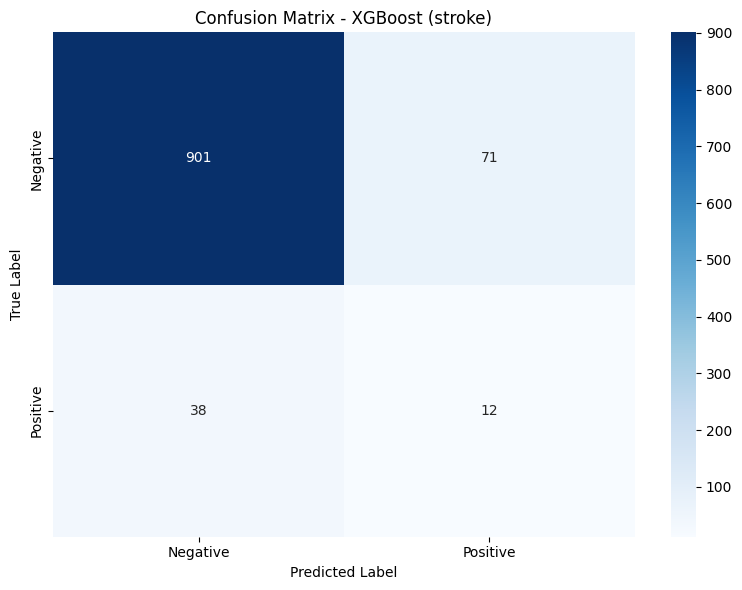

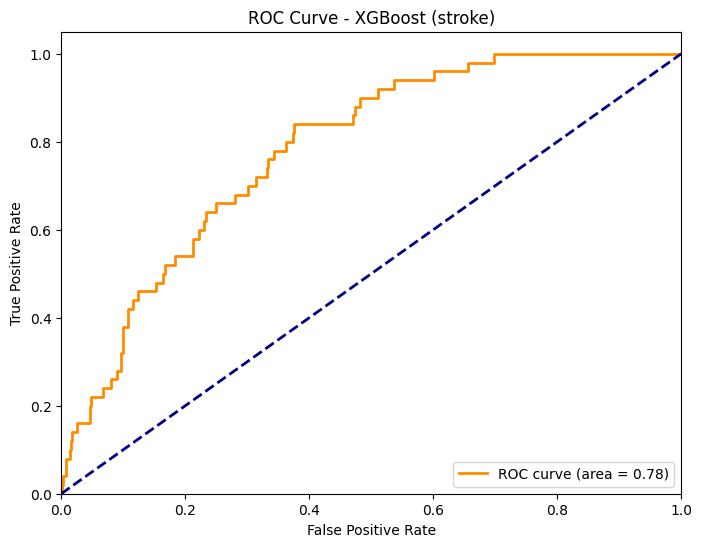

Model saved to /workspace/COMP-3608---PROJECT/models/stroke_xgboost.pkl


In [34]:
# STROKE DATASET EVALUATION
print("\nLoading Stroke Dataset...")
stroke_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/Stroke_feature_engineering'))

# For stroke dataset, many columns are already one-hot encoded
stroke_cat_cols = ['glucose_risk']
stroke_num_cols = [col for col in stroke_df.columns 
                  if col not in stroke_cat_cols + ['stroke', 'age_group'] 
                  and not col.startswith('gender_') 
                  and not col.startswith('ever_married_')
                  and not col.startswith('work_type_')
                  and not col.startswith('Residence_type_')
                  and not col.startswith('smoking_status_')]

# Prepare data
X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = prepare_data_for_modeling(
    stroke_df, 'stroke', stroke_cat_cols, stroke_num_cols)

# Evaluate models
stroke_results = evaluate_models(X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke, 'stroke')


Loading Heart Disease Dataset...

--------------------------------------------------
Training and evaluating Logistic Regression on heart dataset

Model: Logistic Regression
Accuracy: 0.8315
Precision: 0.8447
Recall: 0.8529
F1 Score: 0.8488

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        82
           1       0.84      0.85      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



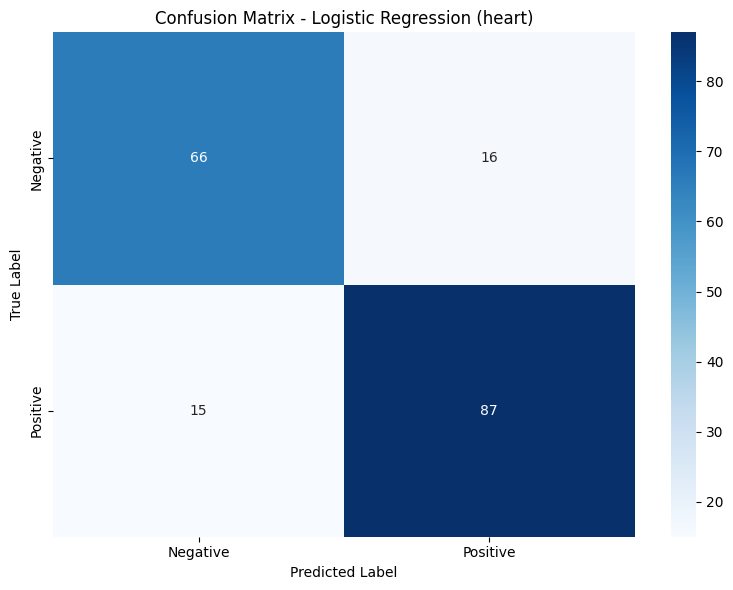

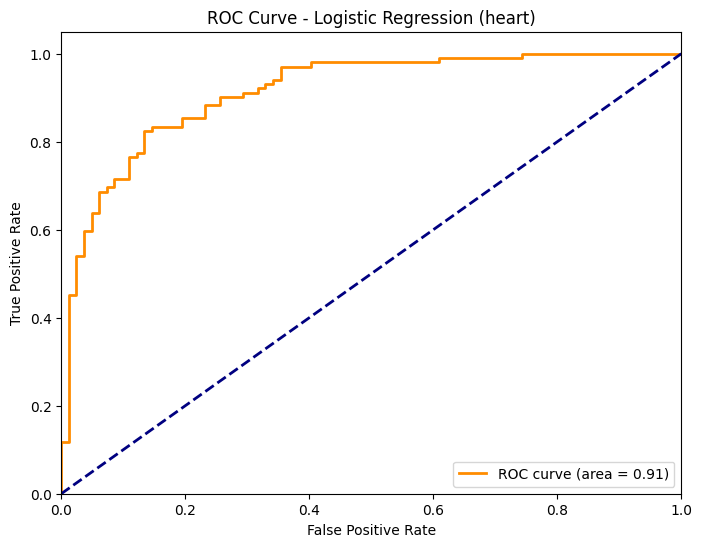

Model saved to /workspace/COMP-3608---PROJECT/models/heart_logistic_regression.pkl

--------------------------------------------------
Training and evaluating Random Forest on heart dataset

Model: Random Forest
Accuracy: 0.8152
Precision: 0.8269
Recall: 0.8431
F1 Score: 0.8350

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        82
           1       0.83      0.84      0.83       102

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.82      0.81       184



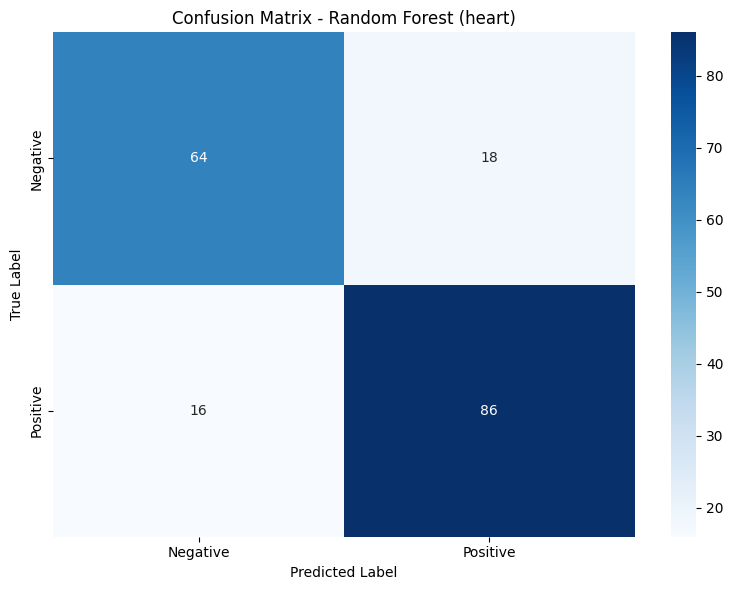

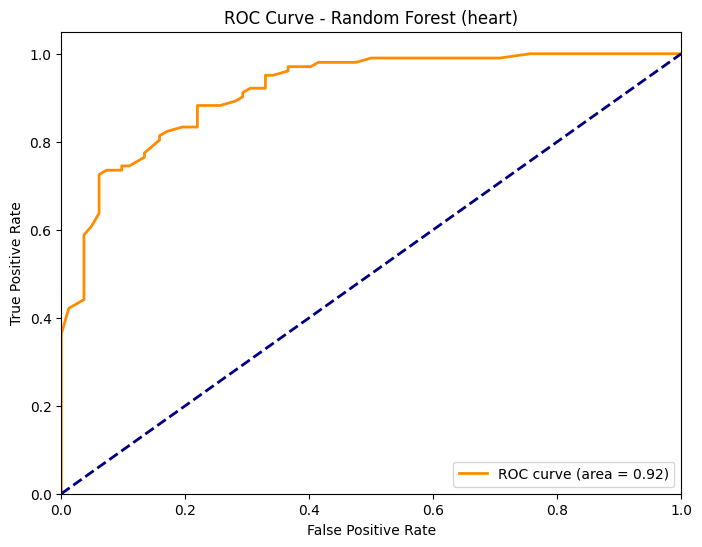

Model saved to /workspace/COMP-3608---PROJECT/models/heart_random_forest.pkl

--------------------------------------------------
Training and evaluating XGBoost on heart dataset

Model: XGBoost
Accuracy: 0.7989
Precision: 0.8218
Recall: 0.8137
F1 Score: 0.8177

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78        82
           1       0.82      0.81      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



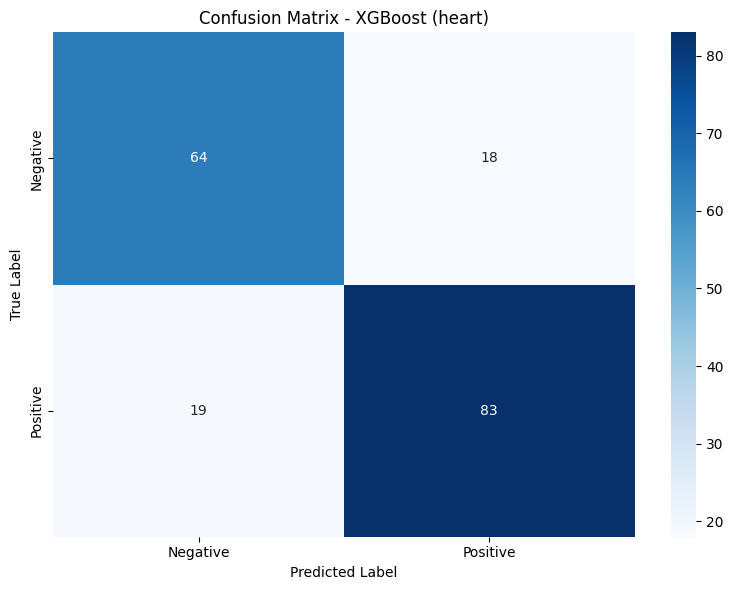

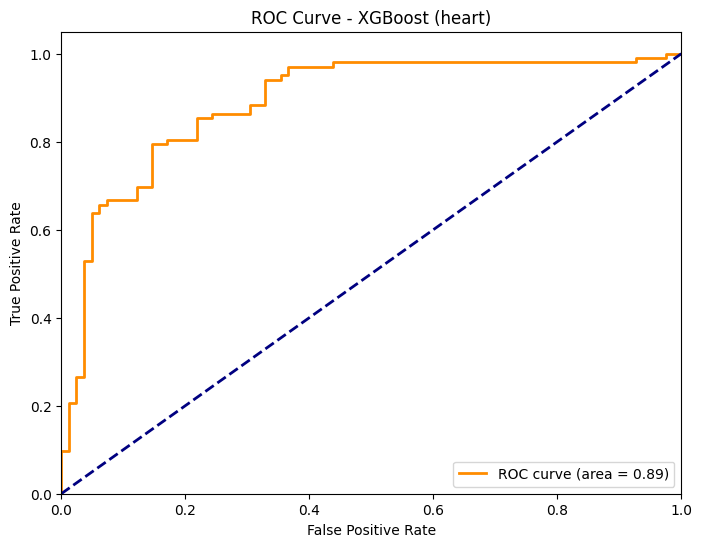

Model saved to /workspace/COMP-3608---PROJECT/models/heart_xgboost.pkl


In [35]:
# 3. HEART DISEASE DATASET EVALUATION
print("\nLoading Heart Disease Dataset...")
heart_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/heart_feature_engineering'))

# Convert 'num' to a binary classification problem if it's not already binary
# If num is continuous, we need to convert it to a binary target
if heart_df['num'].nunique() > 2:
    # Assuming values > 0 indicate presence of heart disease
    heart_df['heart_disease'] = (heart_df['num'] > 0).astype(int)
    target_column = 'heart_disease'
else:
    target_column = 'num'
    print("\nTarget is already binary, using as is")

# Define categorical and numerical columns for heart disease
heart_cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'age_group', 'blood_pressure', 'chol_risk', 'dataset']
heart_num_cols = [col for col in heart_df.columns if col not in heart_cat_cols + [target_column, 'num', 'id']]

# Prepare data
X_train_heart, X_test_heart, y_train_heart, y_test_heart = prepare_data_for_modeling(
    heart_df, target_column, heart_cat_cols, heart_num_cols)

# Evaluate models
heart_results = evaluate_models(X_train_heart, X_test_heart, y_train_heart, y_test_heart, 'heart')


In [36]:
# COMPARISON OF MODEL PERFORMANCE ACROSS DATASETS
def compare_model_performance(diabetes_results, stroke_results, heart_results):
    # Create comparison dataframe
    models = list(diabetes_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    comparison_data = []
    
    for model in models:
        for metric in metrics:
            comparison_data.append({
                'Model': model,
                'Metric': metric,
                'Diabetes': diabetes_results[model][metric],
                'Stroke': stroke_results[model][metric],
                'Heart Disease': heart_results[model][metric]
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        metric_data = comparison_df[comparison_df['Metric'] == metric]
        
        # Reshape for seaborn
        metric_data_melted = pd.melt(
            metric_data, 
            id_vars=['Model', 'Metric'], 
            value_vars=['Diabetes', 'Stroke', 'Heart Disease'],
            var_name='Dataset', 
            value_name='Score'
        )
        
        sns.barplot(x='Model', y='Score', hue='Dataset', data=metric_data_melted)
        plt.title(f'Comparison of {metric.capitalize()} Across Datasets')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Dataset')
        plt.tight_layout()
    
    plt.suptitle('Model Performance Comparison Across Datasets', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return comparison_df

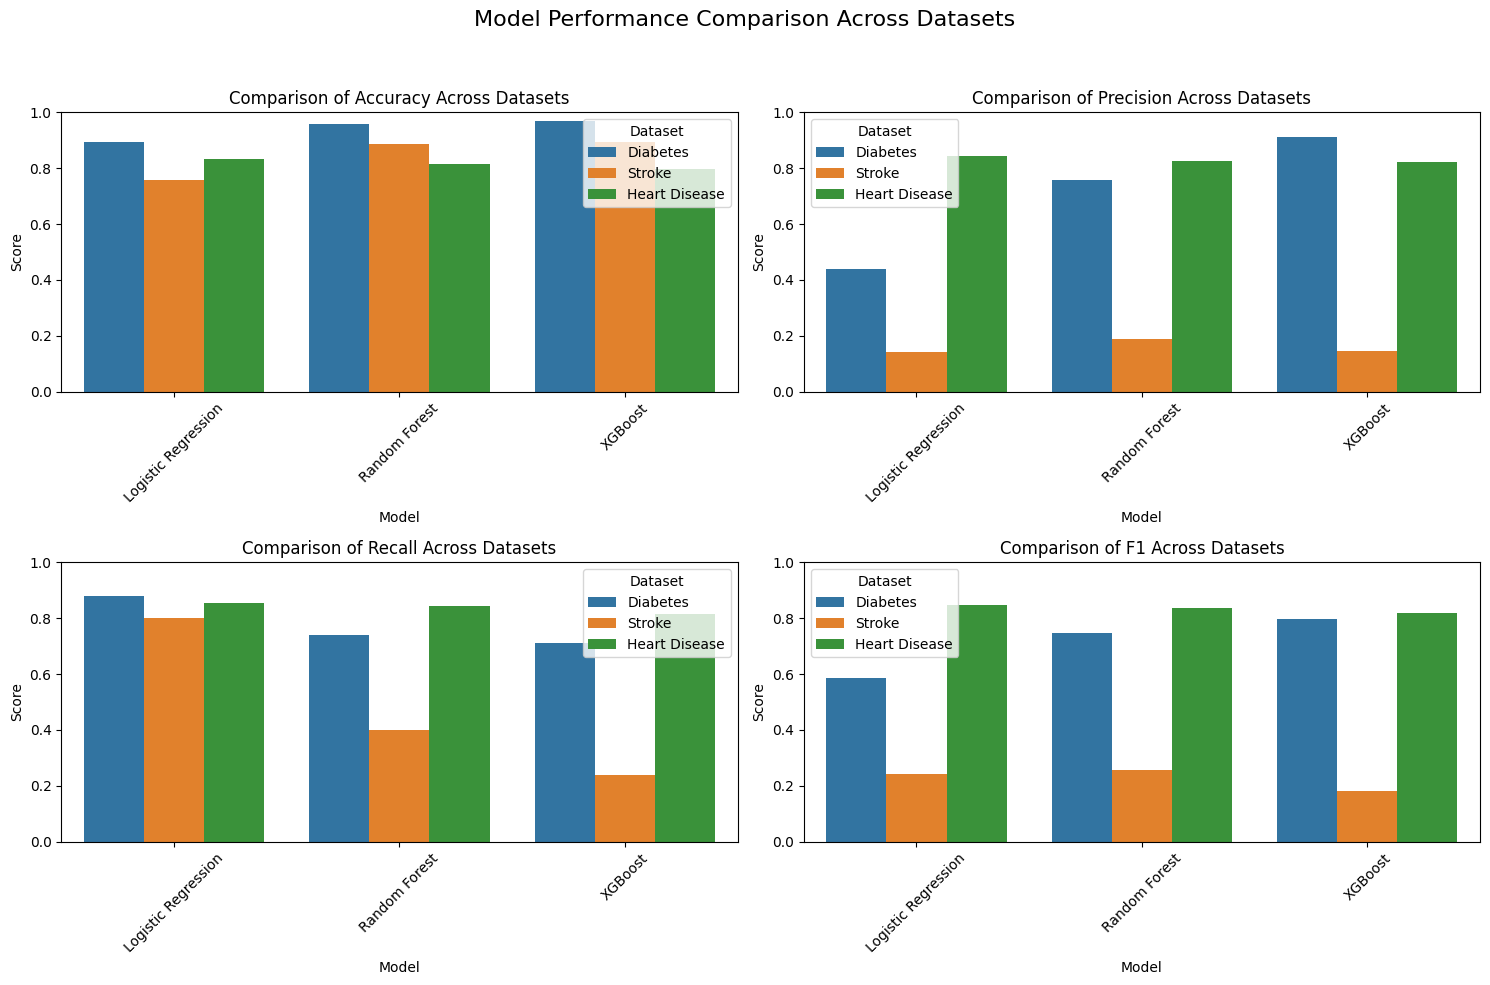


Model Performance Comparison:
                  Model     Metric  Diabetes    Stroke  Heart Disease
0   Logistic Regression   accuracy  0.894000  0.757339       0.831522
1   Logistic Regression  precision  0.438525  0.143885       0.844660
2   Logistic Regression     recall  0.881176  0.800000       0.852941
3   Logistic Regression         f1  0.585614  0.243902       0.848780
4         Random Forest   accuracy  0.957700  0.886497       0.815217
5         Random Forest  precision  0.756303  0.188679       0.826923
6         Random Forest     recall  0.741176  0.400000       0.843137
7         Random Forest         f1  0.748663  0.256410       0.834951
8               XGBoost   accuracy  0.969400  0.893346       0.798913
9               XGBoost  precision  0.910256  0.144578       0.821782
10              XGBoost     recall  0.710000  0.240000       0.813725
11              XGBoost         f1  0.797753  0.180451       0.817734
Comparison results saved to /workspace/COMP-3608---PROJECT/

In [37]:

# Compare model performance
comparison_df = compare_model_performance(diabetes_results, stroke_results, heart_results)
print("\nModel Performance Comparison:")
print(comparison_df.to_string())

# Save comparison results
comparison_df.to_csv(os.path.join(BASE_PATH, 'results/model_comparison.csv'), index=False)
print(f"Comparison results saved to {os.path.join(BASE_PATH, 'results/model_comparison.csv')}")